### Model: InceptionResNetV2

## Import Libraries & Load Data

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from data_loader import load_dir, split_data, create_dataset, data_augmentation

2024-08-07 16:48:07.566576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 16:48:07.575862: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 16:48:07.648827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 16:48:07.765255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 16:48:07.828195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# define 
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size=(299,299) #NASnet requires a larger image size
num_classes=2

In [3]:
# Load images and labels
train_images, train_labels = load_dir(train_dir, classes, max_images, image_size)
test_images, test_labels = load_dir(test_dir, classes, max_images, image_size)

In [4]:
# Split the training data into train and validation sets
train_images, train_labels, val_images, val_labels = split_data(train_images, train_labels, val_split=0.2)

In [5]:
# Create train and validation datasets
train_ds = create_dataset(train_images, train_labels, batch_size=10)
val_ds = create_dataset(val_images, val_labels, batch_size=10)

test_ds = create_dataset(test_images, test_labels, batch_size=10)

## Train Model

In [6]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of InceptionResNetV2 and freeze the weights
    backbone = keras.applications.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.inception_resnet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [7]:
model = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [8]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # changed to updated optimizer API
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - acc: 0.4454 - loss: 0.6956 - val_acc: 0.6625 - val_loss: 0.6039
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - acc: 0.6401 - loss: 0.6231 - val_acc: 0.7375 - val_loss: 0.5748
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - acc: 0.7207 - loss: 0.5761 - val_acc: 0.7500 - val_loss: 0.5546
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - acc: 0.7523 - loss: 0.5416 - val_acc: 0.7750 - val_loss: 0.5283
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - acc: 0.7838 - loss: 0.5780 - val_acc: 0.8375 - val_loss: 0.5005
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - acc: 0.7956 - loss: 0.4846 - val_acc: 0.8500 - val_loss: 0.4803
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - acc: 0.9089 - loss: 0.4588 - val_acc: 0.8750 - val_loss: 0.4605
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - acc: 0.8449 - loss: 0.4313 - val_acc: 0.8875 - val_loss: 0.4423
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - acc: 0.7403 - loss: 0.5482 - val_acc: 

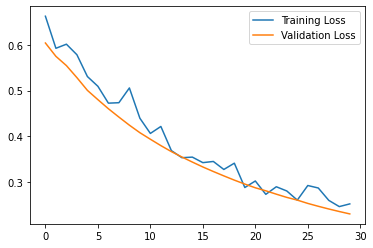

In [9]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

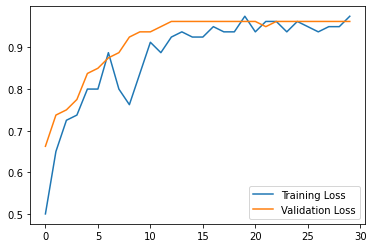

In [10]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [11]:
# save model

model_dir='Models'
os.makedirs(model_dir,exist_ok=True)

model_path=os.path.join(model_dir,'InceptionResNet.keras')
model.save(model_path)